In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(14*5)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.102:40362 Dashboard: http://10.148.0.102:8787/status,Cluster Workers: 70 Cores: 70 Memory: 1.09 TiB


_________
# 1. Read dataset



## Raw output

In [5]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_zarr+'W_total_rechunk.zarr')
ds_B = xr.open_zarr(out_dir_zarr+'Buoy_total_rechunk.zarr')
ds_MLD = xr.open_zarr(out_dir_zarr+'mld_filter.zarr')

ds = xr.merge([ds_U,ds_V,ds_W,ds_B,ds_MLD,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/22)
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    ...          ...
    dyG         (lat, lon_g) float32 ...
    rA          (lat, lon) float32 ...
    rAz         (lat_g, lon_g) float32 ...
    rAw         (lat, lon_g) float32 ...
    rAs         (lat_g, lon) float32 ...
  * depth_left  (depth_left) float64 -0.035 1.035 2.18 ... 878.0 922.9 968.9
Data variables:
    U           (time, depth, lat, lon_g) float32 dask.array<chunksize=(9415, 1,

In [6]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic, boundary=None):
  * center   lat --> left
  * left     lat_g --> center
Z Axis (not periodic, boundary=None):
  * center   depth --> left
  * left     depth_left --> center


# Filtered

In [7]:
# Calculate vertical distances located on the cellboundary
ds.coords['dzc'] = gridx.diff(ds.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds.coords['dzt'] = gridx.diff(ds.depth_left, 'Z', boundary='extrapolate')

lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')

In [8]:
out_dir_zarr = '/home1/scratch/xyu/KE/data_rechunk_filter/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds_U_lowpass = xr.open_zarr(out_dir_zarr+'U_1day_lowpass_filter.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_zarr+'V_1day_lowpass_filter.zarr')
ds_W_lowpass = xr.open_zarr(out_dir_zarr+'W_1day_lowpass_filter.zarr')
ds_B_lowpass = xr.open_zarr(out_dir_zarr+'B_1day_lowpass_filter.zarr')

ds_filter = xr.merge([ds_U_lowpass,ds_V_lowpass,ds_W_lowpass,ds_B_lowpass,grid])

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds_filter = ds_filter.assign_coords(time=time_day) 
print(ds_filter)
print('\n data size: %.1f GB' %(ds_filter.nbytes / 1e9))

<xarray.Dataset>
Dimensions:       (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/21)
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon_g         (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g         (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    ...            ...
    dxG           (lat_g, lon) float32 ...
    dyG           (lat, lon_g) float32 ...
    rA            (lat, lon) float32 ...
    rAz           (lat_g, lon_g) float32 ...
    rAw           (lat, lon_g) float32 ...
    rAs           (lat_g, lon) float32 ...
Data variables:
    U_low_filter  (time, depth, lat, lon_g) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>
    V_l

______________
# 2. Parameter

## 2.1 Frontogenesis (e.g., Fs, Tb, and grad b)

## Tb

In [9]:
db_dx = gridx.diff(ds_filter['B_low_filter'],'X')/ds_filter.dxC     # db/dx
db_dx_ij = gridx.interp(db_dx,'X')

db_dy = gridx.diff(ds_filter['B_low_filter'],'Y')/ds_filter.dyC     # db/dy
db_dy_ij = gridx.interp(db_dy,'Y')

du_dx_ij = gridx.diff(ds_filter['U_low_filter'], 'X')/gridx.interp(ds_filter.dxG, 'Y')

dU_dy_1 = gridx.diff(ds_filter['U_low_filter'], 'Y')/gridx.interp(ds_filter.dyC, 'X')
dU_dy_2 = gridx.interp(dU_dy_1, 'X')
du_dy_ij = gridx.interp(dU_dy_2, 'Y')

dV_dx_1 = gridx.diff(ds_filter['V_low_filter'], 'X')/gridx.interp(ds_filter.dxC, 'Y')
dV_dx_2 = gridx.interp(dV_dx_1, 'X')
dv_dx_ij = gridx.interp(dV_dx_2, 'Y')

dv_dy_ij = gridx.diff(ds_filter['V_low_filter'], 'Y')/gridx.interp(ds_filter.dyG, 'X')

Fs_filter = -(du_dx_ij*db_dx_ij*db_dx_ij + dv_dx_ij*db_dx_ij*db_dy_ij + du_dy_ij*db_dx_ij*db_dy_ij + dv_dy_ij*db_dy_ij*db_dy_ij)
lateral_buoyancy_gradient_filter = np.sqrt(db_dx_ij*db_dx_ij + db_dy_ij*db_dy_ij)

In [ ]:
lbg_filter_rms = (lateral_buoyancy_gradient_filter**2).mean(['lat','lon','time','depth'])
lbg_filter_rms.load()

In [11]:
lbg_filter_rms = 5.4257928e-15

In [12]:
Tb_filter = Fs_filter/(db_dx_ij*db_dx_ij + db_dy_ij*db_dy_ij + lbg_filter_rms)
Tb_filter_f = (Tb_filter/f_ij)

## Tv

In [36]:
du_dx_ij = gridx.diff(ds_filter['U_low_filter'], 'X')/gridx.interp(ds_filter.dxG, 'Y')

dU_dy_1 = gridx.diff(ds_filter['U_low_filter'], 'Y')/gridx.interp(ds_filter.dyC, 'X')
dU_dy_2 = gridx.interp(dU_dy_1, 'X')
du_dy_ij = gridx.interp(dU_dy_2, 'Y')

dV_dx_1 = gridx.diff(ds_filter['V_low_filter'], 'X')/gridx.interp(ds_filter.dxC, 'Y')
dV_dx_2 = gridx.interp(dV_dx_1, 'X')
dv_dx_ij = gridx.interp(dV_dx_2, 'Y')

dv_dy_ij = gridx.diff(ds_filter['V_low_filter'], 'Y')/gridx.interp(ds_filter.dyG, 'X')

lateral_velocity_gradient_filter = np.sqrt(du_dx_ij*du_dx_ij + dv_dy_ij*dv_dy_ij)

In [37]:
lvg_filter_rms =  (lateral_velocity_gradient_filter**2).mean(['lat','lon','time','depth']) 
lvg_filter_rms.load()

<xarray.DataArray ()>
array(3.7158118e-10, dtype=float32)

In [52]:
Tv_filter_1 = du_dx_ij*du_dx_ij*du_dx_ij + du_dx_ij*dv_dx_ij*dv_dx_ij + du_dx_ij*du_dy_ij*du_dy_ij
Tv_filter_2 = du_dy_ij*dv_dx_ij*dv_dy_ij + du_dy_ij*dv_dx_ij*du_dx_ij
Tv_filter_3 = dv_dy_ij*dv_dy_ij*dv_dy_ij + dv_dy_ij*du_dy_ij*du_dy_ij + dv_dy_ij*dv_dx_ij*dv_dx_ij

Tv_filter = -(Tv_filter_1 + Tv_filter_2 + Tv_filter_3)/(du_dx_ij*du_dx_ij + dv_dy_ij*dv_dy_ij + lvg_filter_rms)
Tv_filter_f = (Tv_filter/f_ij)

## 2.2 Horizontal divergence

In [13]:
#vel_div_components = gridx.diff_2d_vector({'X': ds.dyG * ds['U'], 'Y': ds.dxG * ds['V']}, boundary='extend')
#vel_div = (vel_div_components['X'] + vel_div_components['Y'])/ds.rA
#vel_div_f = (vel_div/f_ij)

vel_div_components_filter = gridx.diff_2d_vector({'X': ds.dyG * ds_filter['U_low_filter'], 'Y': ds.dxG * ds_filter['V_low_filter']}, boundary='extend')
vel_div_filter = (vel_div_components_filter['X'] + vel_div_components_filter['Y'])/ds.rA
vel_div_filter_f = (vel_div_filter/f_ij)
vel_div_filter_f = vel_div_filter_f.drop(['XC','YC','CS','SN','Depth','rA'])
vel_div_filter_f

,Array,Chunk
Bytes,64.89 GiB,6.32 MiB
Shape,"(201, 177, 9415, 52)","(1, 176, 9415, 1)"
Count,316082 Tasks,20904 Chunks
Type,float32,numpy.ndarray


## 2.3 Relative vorticity

In [35]:
zeta_filter = (gridx.diff(ds_filter.dyC*ds_filter['V_low_filter'],'X') - gridx.diff(ds_filter.dxC * ds_filter['U_low_filter'],'Y'))/ds_filter.rAz
zeta_filter_ij = gridx.interp(gridx.interp(zeta_filter, 'Y'), 'X')
zeta_filter_f = (zeta_filter_ij/f_ij)

<xarray.DataArray (lat: 201, lon: 177, time: 9415, depth: 52)>
dask.array<truediv, shape=(201, 177, 9415, 52), dtype=float32, chunksize=(1, 175, 9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3


## 2.4 Horizontal strain

In [ ]:
normal_shear = (gridx.diff(ds_filter['U_low_filter'] * ds.dyG, 'X') - gridx.diff(ds_filter['V_low_filter']* ds.dxG, 'Y')) / ds.rA

dV_dx_1 = gridx.diff(ds_filter['V_low_filter'], 'X')/gridx.interp(ds_filter.dxC, 'Y')
dV_dx_2 = gridx.interp(dV_dx_1, 'X')
dv_dx_ij = gridx.interp(dV_dx_2, 'Y')

dU_dy_1 = gridx.diff(ds_filter['U_low_filter'], 'Y')/gridx.interp(ds_filter.dyC, 'X')
dU_dy_2 = gridx.interp(dU_dy_1, 'X')
du_dy_ij = gridx.interp(dU_dy_2, 'Y')

shear_strain = (dv_dx_ij + du_dy_ij)

strain_filter_f = (normal_shear**2 + shear_strain**2)**0.5/f_ij
strain_filter_f = strain_filter_f.drop(['XC','YC','CS','SN','Depth','rA'])

___________
# 3. Save estimates

In [14]:
out_dir_store = '/home1/scratch/xyu/KE/parameter/'
depth_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

In [15]:
# 15 mins
VV = ['Tb_filter_f']

for depth in depth_all:
    
    for vv in VV:
        
        Tb_single = Tb_filter_f.isel(depth=depth)
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        Tb_single = Tb_single.chunk(chunks)
        Tb_single = np.real(Tb_single).rename('Tb_single')     
        Tb_single = Tb_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        Tb_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

In [21]:
# 16 mins
VV = ['Tv_filter_f']

for depth in depth_all:
    
    for vv in VV:
        
        Tv_single = Tv_filter_f.isel(depth=depth)
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        Tv_single = Tv_single.chunk(chunks)
        Tv_single = np.real(Tv_single).rename('Tv_single')     
        Tv_single = Tv_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        Tv_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

In [16]:
# 5 mins
VV = ['div_filter_f']

for depth in depth_all:
    
    for vv in VV:
        
        div_single = vel_div_filter_f.isel(depth=depth)
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        div_single = div_single.chunk(chunks)
        div_single = np.real(div_single).rename('div_single')     
        div_single = div_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        div_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

In [15]:
# 10 mins
VV = ['lbg_filter']

for depth in depth_all:
    
    for vv in VV:
        
        lbg_single = lateral_buoyancy_gradient_filter.isel(depth=depth)
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        lbg_single = lbg_single.chunk(chunks)
        lbg_single = np.real(lbg_single).rename('lbg_single')     
        lbg_single = lbg_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        lbg_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed


In [17]:
# 25 mins
VV = ['Fs_filter']

for depth in depth_all:
    
    for vv in VV:
        
        Fs_single = Fs_filter.isel(depth=depth)
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        Fs_single = Fs_single.chunk(chunks)
        Fs_single = np.real(Fs_single).rename('Fs_single')     
        Fs_single = Fs_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        Fs_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

In [43]:
# 25 mins
VV = ['strain_filter_f']

for depth in depth_all:
    
    for vv in VV:
        
        strain_single = strain_filter_f.isel(depth=depth)
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        strain_single = strain_single.chunk(chunks)
        strain_single = np.real(strain_single).rename('strain_single')     
        strain_single = strain_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        strain_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

In [37]:
# 25 mins
VV = ['zeta_filter_f']

for depth in depth_all:
    
    for vv in VV:
        
        zeta_single = zeta_filter_f.isel(depth=depth)
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        zeta_single = zeta_single.chunk(chunks)
        zeta_single = np.real(zeta_single).rename('zeta_single')     
        zeta_single = zeta_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        zeta_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

# 4. Read results

In [5]:
out_dir_store = '/home1/scratch/xyu/KE/parameter/'

D = [xr.open_zarr(out_dir_store+'Tb_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
Tb = xr.concat(D, dim='depth')
Tb = Tb.Tb_single
Tb

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [6]:
out_dir_store = '/home1/scratch/xyu/KE/parameter/'

D = [xr.open_zarr(out_dir_store+'Tv_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
Tv = xr.concat(D, dim='depth')
Tv = Tv.Tv_single
Tv

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [7]:
out_dir_store = '/home1/scratch/xyu/KE/parameter/'
D = [xr.open_zarr(out_dir_store+'div_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
div = xr.concat(D, dim='depth')
div = div.div_single
div

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 201, 177, 9415)","(1, 1, 177, 9415)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [18]:
out_dir_store = '/home1/scratch/xyu/KE/parameter/'
D = [xr.open_zarr(out_dir_store+'lbg_filter_d%02d.zarr'%(depth)) for depth in range(52)]
lbg = xr.concat(D, dim='depth')
lbg = lbg.lbg_single
lbg

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [19]:
D = [xr.open_zarr(out_dir_store+'Fs_filter_d%02d.zarr'%(depth)) for depth in range(52)]
Fs = xr.concat(D, dim='depth')
Fs = Fs.Fs_single
Fs

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [20]:
D = [xr.open_zarr(out_dir_store+'zeta_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
zeta = xr.concat(D, dim='depth')
zeta = zeta.zeta_single
zeta

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 201, 177, 9415)","(1, 1, 177, 9415)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [21]:
D = [xr.open_zarr(out_dir_store+'strain_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
strain = xr.concat(D, dim='depth')
strain = strain.strain_single
strain

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


________________
# 5. Frontogenesis mechanism

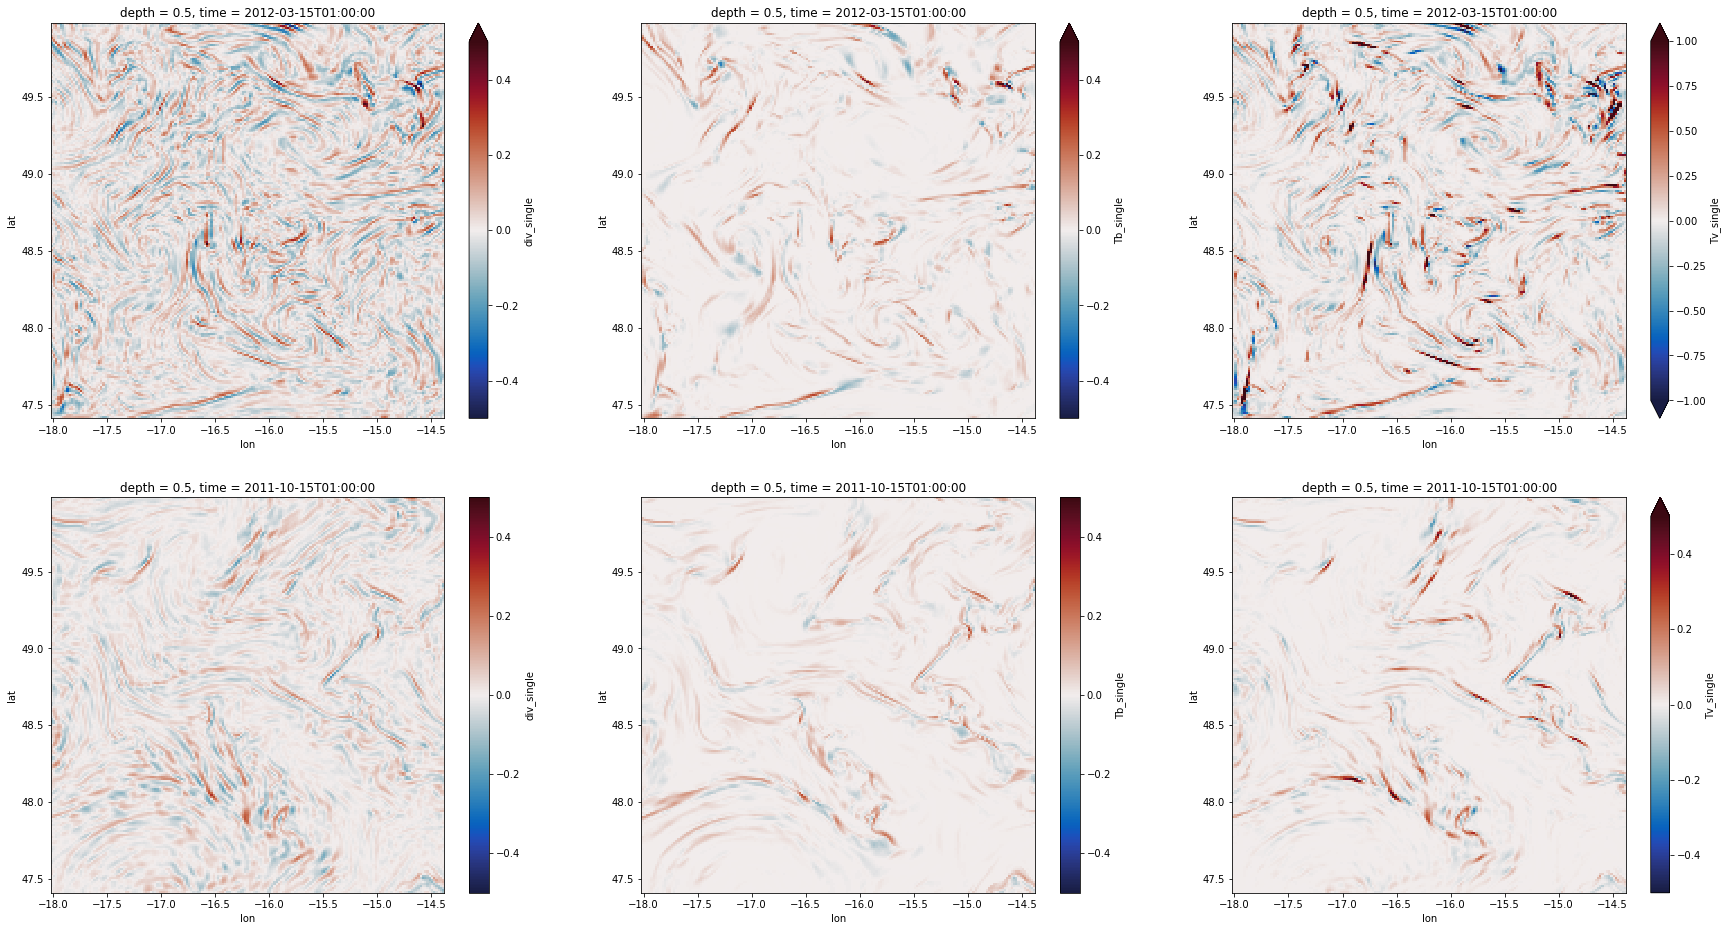

In [61]:
fig = plt.figure(figsize=(30,16))

plt.subplot(231)
(-1*div.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00')).plot(x='lon', y='lat', vmin=-0.5, vmax=0.5, cmap=cm.balance)

plt.subplot(232)
Tb.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=-0.5, vmax=0.5, cmap=cm.balance)

plt.subplot(233)
Tv.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance)

plt.subplot(234)
(-1*div.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2011-10-15T01:00:00')).plot(x='lon', y='lat', vmin=-0.5, vmax=0.5, cmap=cm.balance)

plt.subplot(235)
Tb.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2011-10-15T01:00:00').plot(x='lon', y='lat', vmin=-0.5, vmax=0.5, cmap=cm.balance)

plt.subplot(236)
Tv.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2011-10-15T01:00:00').plot(x='lon', y='lat', vmin=-0.5, vmax=0.5, cmap=cm.balance)

(500.0, 0.0)

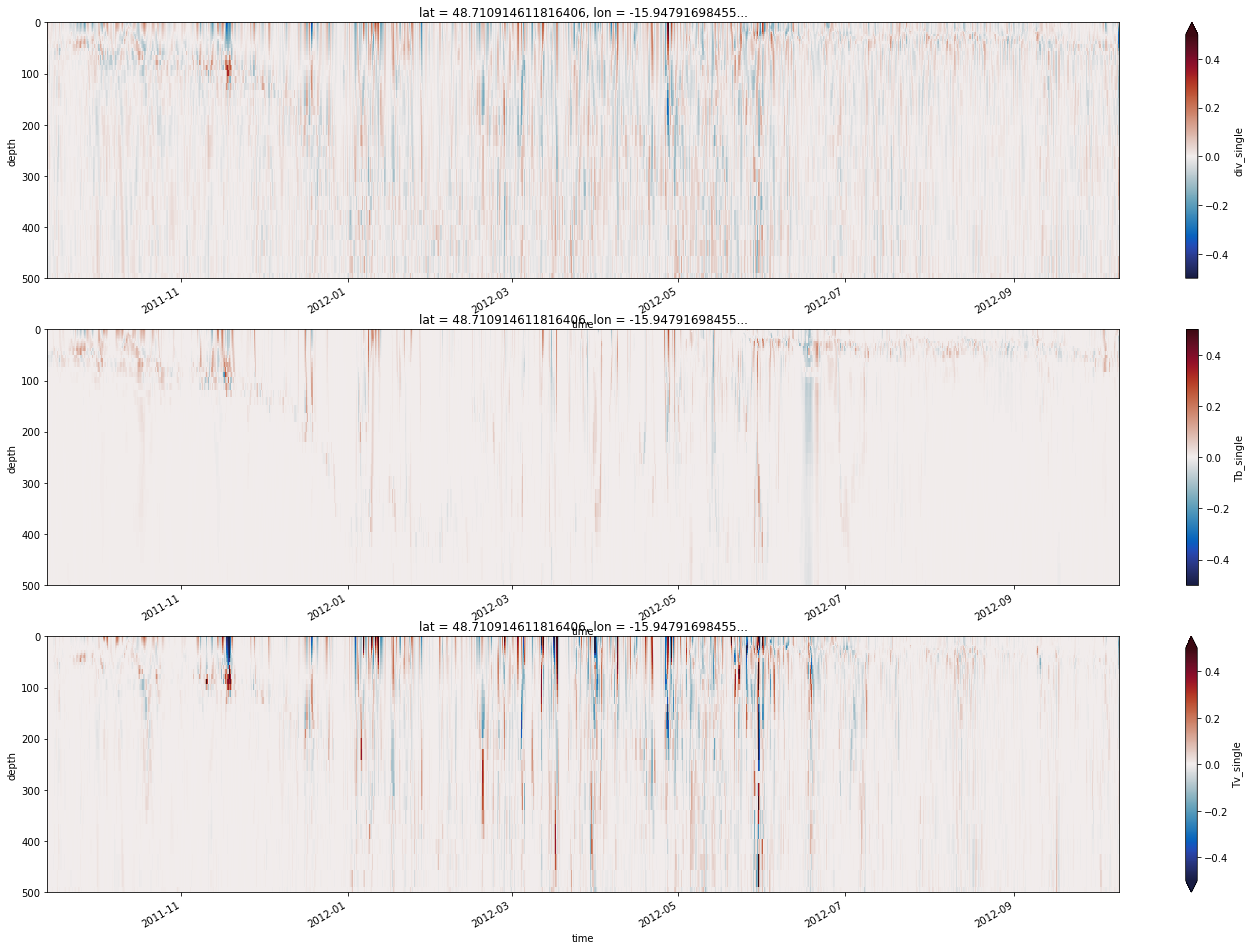

In [25]:
fig = plt.figure(figsize=(24,16))

ax = plt.subplot(311)
(-1*div.isel(lat=100,lon=100)).plot(x='time', y='depth', vmin=-0.5, vmax=0.5, cmap=cm.balance, yincrease=False)
ax.set_ylim([500., 0.])

ax = plt.subplot(312)
(Tb.isel(lat=100,lon=100)).plot(x='time', y='depth', vmin=-0.5, vmax=0.5, cmap=cm.balance, yincrease=False)
ax.set_ylim([500., 0.])

ax = plt.subplot(313)
(Tv.isel(lat=100,lon=100)).plot(x='time', y='depth', vmin=-0.5, vmax=0.5, cmap=cm.balance, yincrease=False)
ax.set_ylim([500., 0.])

In [58]:
div_rms =  np.sqrt(div**2).mean(['lat','lon']) 
Tb_rms =  np.sqrt(Tb**2).mean(['lat','lon'])
Tv_rms =  np.sqrt(Tv**2).mean(['lat','lon']) 

(500.0, 0.0)

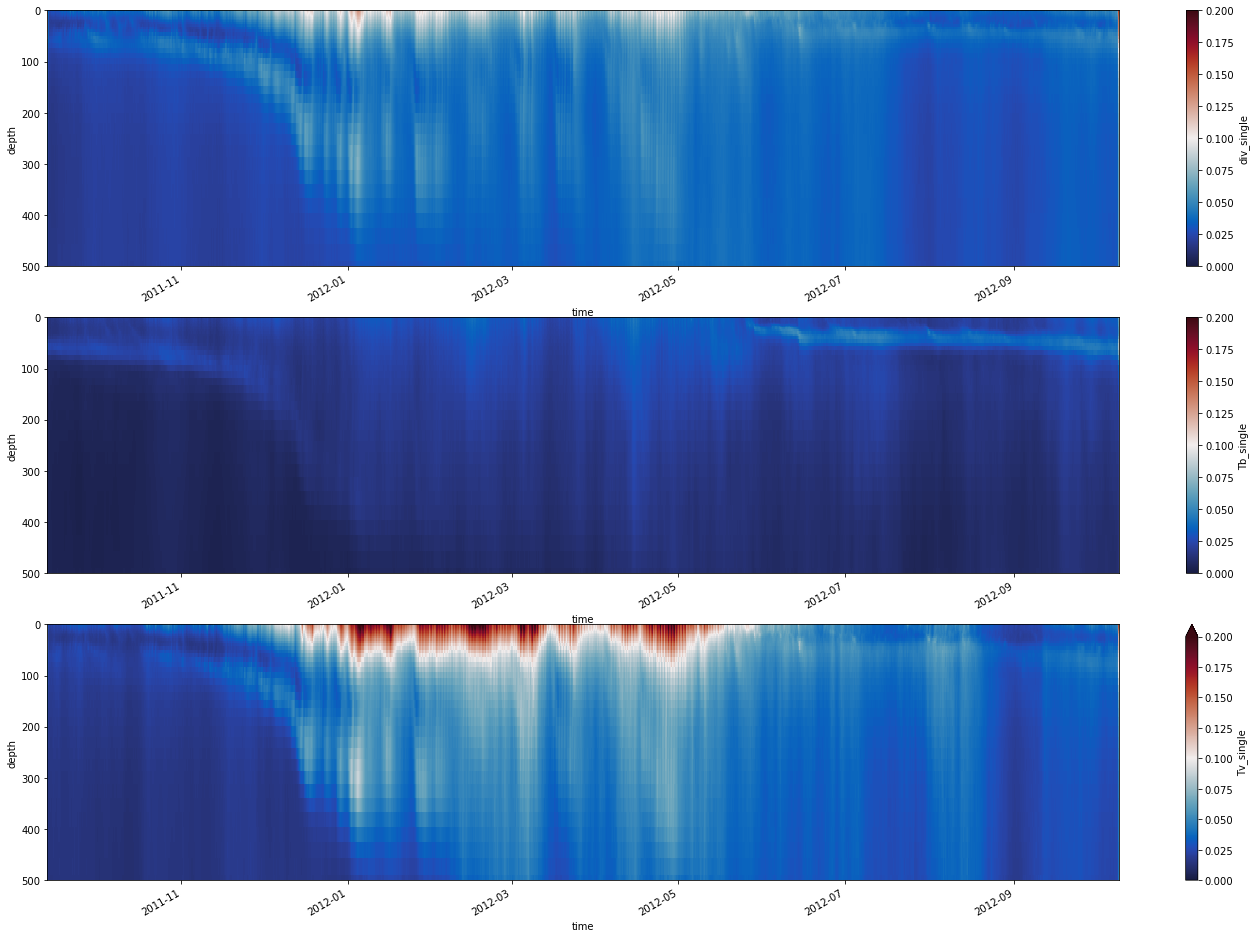

In [60]:
fig = plt.figure(figsize=(24,16))

ax = plt.subplot(311)
div_rms.plot(x='time', y='depth', vmin=0, vmax=0.2, cmap=cm.balance, yincrease=False)
ax.set_ylim([500., 0.])

ax = plt.subplot(312)
Tb_rms.plot(x='time', y='depth', vmin=0, vmax=0.2, cmap=cm.balance, yincrease=False)
ax.set_ylim([500., 0.])

ax = plt.subplot(313)
Tv_rms.plot(x='time', y='depth', vmin=0, vmax=0.2, cmap=cm.balance, yincrease=False)
ax.set_ylim([500., 0.])

## connection

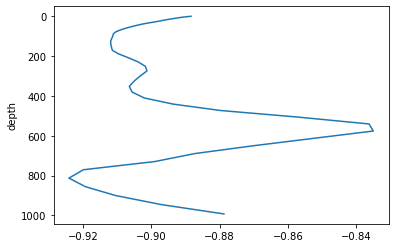

In [28]:
sub = 4
a = xr.corr(Tb.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub)).sel(time=slice('2012-01-01T00:00:00','2012-05-01T00:00:00')),
            div.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub)).sel(time=slice('2012-01-01T00:00:00','2012-05-01T00:00:00')),
            dim=['lat','lon','time']
           )
a.plot(y='depth', yincrease=False)

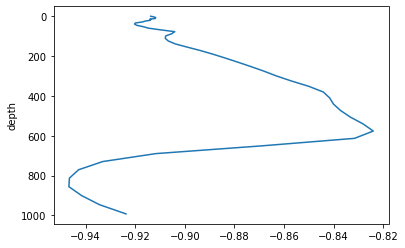

In [29]:
sub = 4
a = xr.corr(Tb.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub)).sel(time=slice('2012-05-01T00:00:00','2012-09-01T00:00:00')),
            div.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub)).sel(time=slice('2012-05-01T00:00:00','2012-09-01T00:00:00')),
            dim=['lat','lon','time']
           )
a.plot(y='depth', yincrease=False)

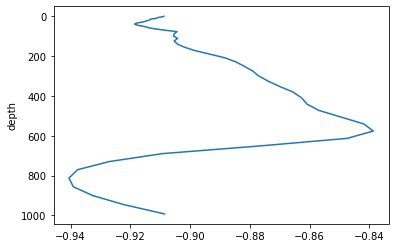

In [31]:
sub = 4
a = xr.corr(Tb.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 24)),
            div.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 24)),
            dim=['lat','lon','time']
           )
a.plot(y='depth', yincrease=False)

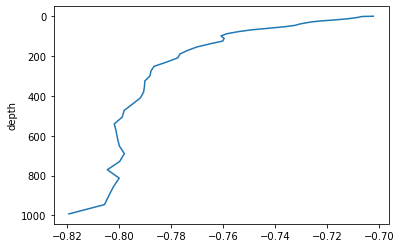

In [30]:
sub = 4
b = xr.corr(Tv.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 24)),
            div.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 24)),
            dim=['lat','lon','time']
           )
b.plot(y='depth', yincrease=False)

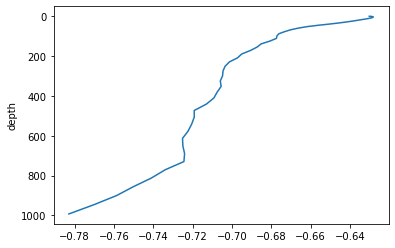

In [32]:
sub = 4
b = xr.corr(Tv.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub)).sel(time=slice('2012-01-01T00:00:00','2012-05-01T00:00:00')),
            div.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub)).sel(time=slice('2012-01-01T00:00:00','2012-05-01T00:00:00')),
            dim=['lat','lon','time']
           )
b.plot(y='depth', yincrease=False)

In [36]:
zeta

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 201, 177, 9415)","(1, 1, 177, 9415)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [28]:
from dask.array import stats

In [29]:
from scipy.stats import skew

In [30]:
vel_div_filter_f.isel(lat=100, lon=100).dims

('time', 'depth')

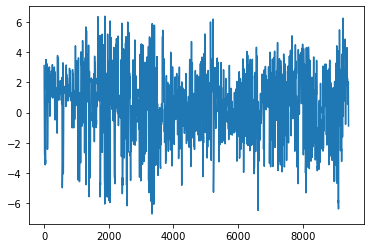

In [32]:
s = skew(Tb.isel(lat=100, lon=100,dep))
plt.plot(s)

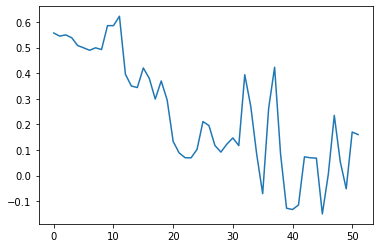

In [43]:
s = skew(Tb_filter_f.isel(lat=100, lon=100))
plt.plot(s)

In [29]:
s = stats.skew(vel_div_f.isel(lat=100, lon=100,depth=0))
dask.compute(s)

(array(-0.38112584, dtype=float32),)

In [30]:
s = stats.skew(vel_div_filter_f.isel(lat=100, lon=100,depth=0))
dask.compute(s)

(array(-0.42492244, dtype=float32),)

In [33]:
t = stats.skew(Tb.isel(lat=10, lon=10,depth=0))
dask.compute(t)

(3.2695606,)

In [32]:
t = stats.skew(Tb_filter_f.isel(lat=100, lon=100,depth=0))
dask.compute(t)

(array(0.557132, dtype=float32),)

In [39]:
z = stats.skew(zeta.isel(lat=100, lon=100,depth=0))
dask.compute(z)

(0.2465056,)

In [35]:
z = stats.skew(zeta_filter_f.isel(lat_g=100, lon_g=100,depth=0))
dask.compute(z)

(array(0.5806472, dtype=float32),)

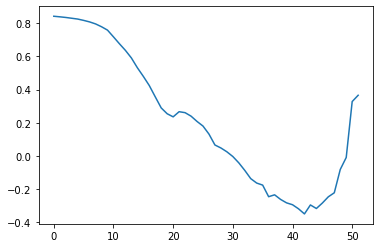

In [37]:
z = skew(zeta_f.isel(lat_g=100, lon_g=100))
plt.plot(z)

In [40]:
from scipy.stats import pearsonr

In [49]:
corr, _ = pearsonr(Tv.isel(lat=100, lon=100, depth=0), div.isel(lat=100, lon=100, depth=0))
corr

-0.7837423092130293

In [48]:
corr, _ = pearsonr(Tb.isel(lat=100, lon=100, depth=0), div.isel(lat=100, lon=100, depth=0))
corr

-0.5821890364112032

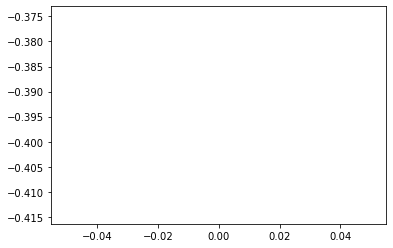

In [46]:
plt.plot(corr)

In [29]:
c = dask.array.corrcoef((-1*vel_div_f.isel(lat=slice(1,-1),lon=slice(1,-1),depth=10).sel(time='2012-03-15T01:00:00')),(Tb_f.isel(lat=slice(1,-1),lon=slice(1,-1),depth=10).sel(time='2012-03-15T01:00:00')))

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/dask/array/routines.py:272: PerformanceWarning: Increasing number of chunks by factor of 398
  axes=(left_axes, right_axes),


_______
# Vorticity-strain space

In [17]:
# Vorticity/f
out_dir_store = '/home1/scratch/xyu/KE/parameter/'
D = [xr.open_zarr(out_dir_store+'zeta_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
zeta = xr.concat(D, dim='depth')
zeta = zeta.zeta_single
zeta

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 201, 177, 9415)","(1, 1, 177, 9415)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [18]:
# Strain/f
D = [xr.open_zarr(out_dir_store+'strain_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
strain = xr.concat(D, dim='depth')
strain = strain.strain_single
strain

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [19]:
D = [xr.open_zarr(out_dir_store+'Tb_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
Tb = xr.concat(D, dim='depth')
Tb = Tb.Tb_single
Tb

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [20]:
D = [xr.open_zarr(out_dir_store+'div_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
div = xr.concat(D, dim='depth')
div = div.div_single
div

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 201, 177, 9415)","(1, 1, 177, 9415)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [21]:
ds_vs = xr.merge([zeta,strain,Tb,div])
print(ds_vs)
print('\n data size: %.1f GB' %(ds_vs.nbytes / 1e9))

<xarray.Dataset>
Dimensions:        (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth          (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * lat            (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon            (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * time           (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Data variables:
    zeta_single    (depth, lat, lon, time) float32 dask.array<chunksize=(1, 1, 177, 9415), meta=np.ndarray>
    strain_single  (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>
    Tb_single      (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>
    div_single     (depth, lat, lon, time) float32 dask.array<chunksize=(1, 1, 177, 9415), meta=np.ndarray>

 data size: 278.7 GB


In [26]:
from xhistogram.xarray import histogram
from matplotlib import colors as cols


Text(0.5, 0, '')

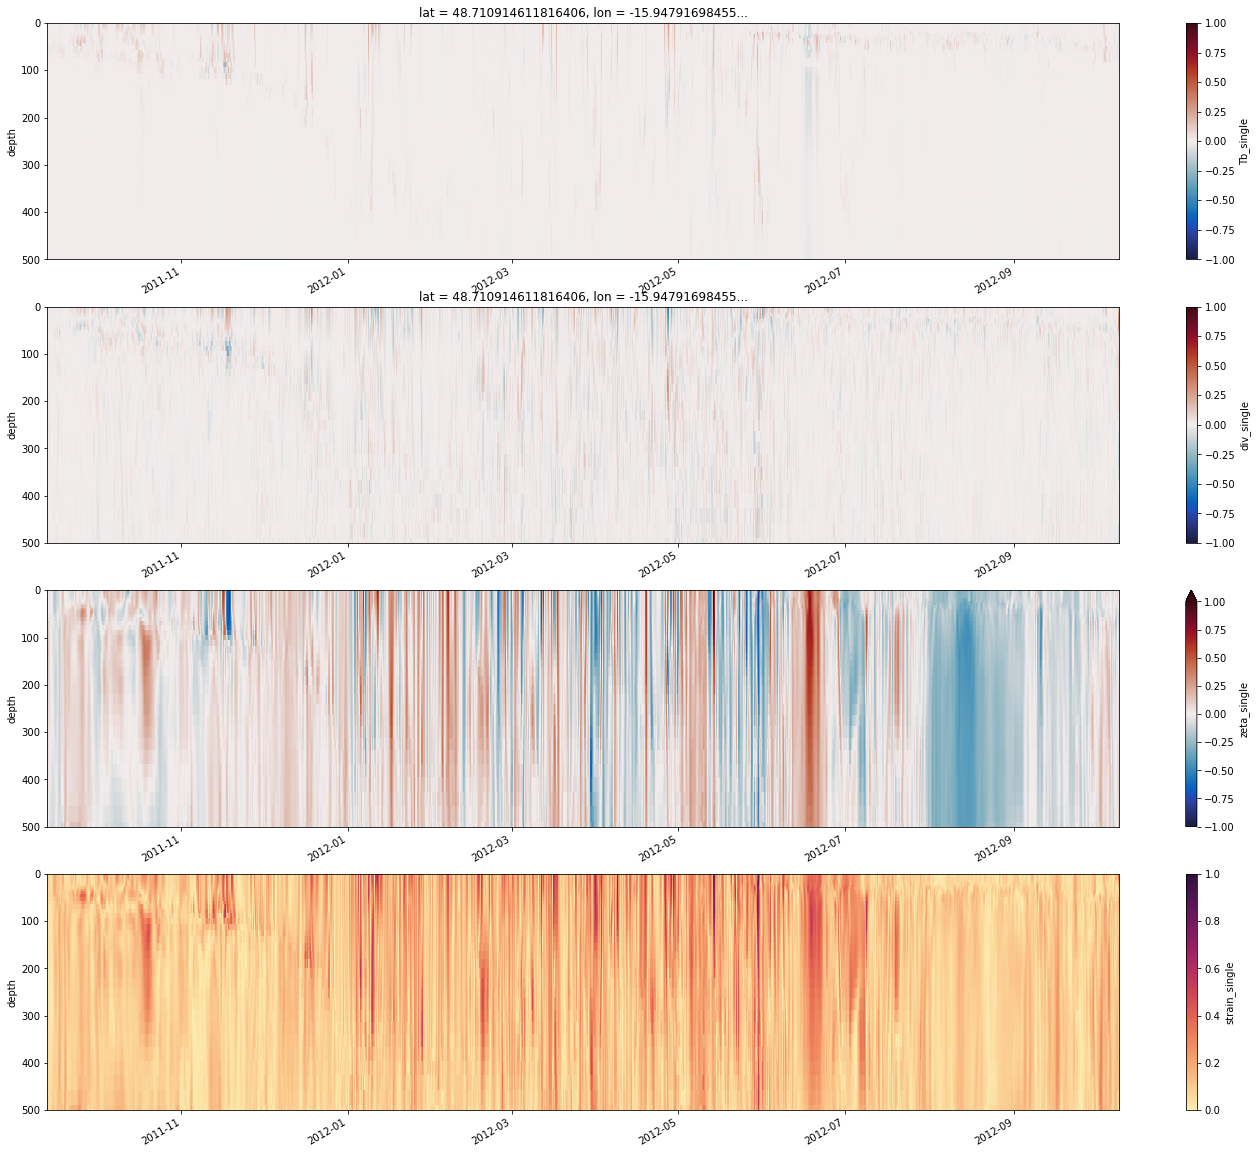

In [29]:
fig = plt.figure(figsize=(24,20))

ax = plt.subplot(411)
ds_vs.Tb_single.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1,vmax=1,cmap=cm.balance, yincrease=False)
ax.set_ylim(500, 0)
plt.xlabel('')

ax = plt.subplot(412)
ds_vs.div_single.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1,vmax=1,cmap=cm.balance, yincrease=False)
ax.set_ylim(500, 0)
plt.xlabel('')

ax = plt.subplot(413)
ds_vs.zeta_single.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1,vmax=1,cmap=cm.balance, yincrease=False)
ax.set_ylim(500, 0)
ax.set_title('')
plt.xlabel('')

ax = plt.subplot(414)
ds_vs.strain_single.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=0,vmax=1,cmap=cm.matter, yincrease=False)
ax.set_ylim(500, 0)
ax.set_title('')
plt.xlabel('')

# Tb

In [24]:
ndepth = [1, 10, 20]
vor_bin = np.linspace(-3, 3, 120)
sr_bin = np.linspace(0, 3, 120)

N = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              bins=[vor_bin, sr_bin], 
              dim=['lat', 'lon'], 
              block_size=None
             )

E = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              bins=[vor_bin, sr_bin], 
              weights= ds_vs.Tb_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(),
              dim=['lat', 'lon'], 
              block_size=None
             )

binbox01 =  (vor_bin[1]-vor_bin[0])*(sr_bin[1]-sr_bin[0])
girbNums01 = (len(ds_vs.zeta_single.lat)-2)*(len(ds_vs.zeta_single.lon)-2)

/dev/shm/pbs.484282.datarmor0/ipykernel_43045/1738851736.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.484282.datarmor0/ipykernel_43045/1738851736.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.484282.datarmor0/ipykernel_43045/1738851736.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eith

Text(0.5, 1.0, 'Tb$_{500m}$ on [$\\zeta$,$\\sigma$]$_{500m}$')

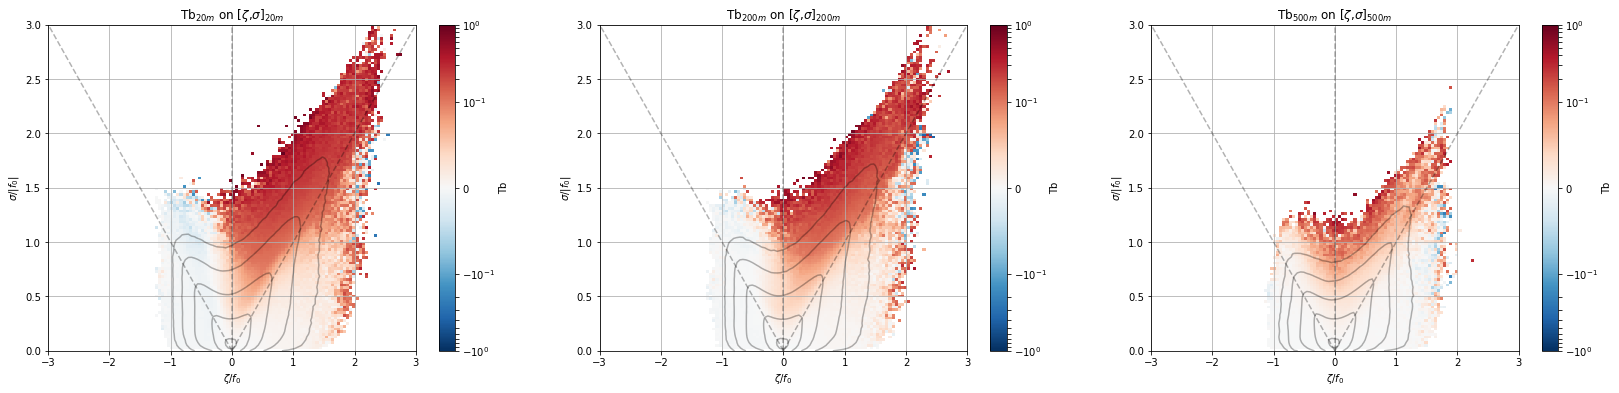

In [33]:
# w
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
W = ((E/N).mean(dim='time').T)*filter01

fig, ax = plt.subplots(figsize=(28,6))

ax = plt.subplot(131)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(1e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('Tb')
ax.set_title('Tb$_{20m}$ on [$\zeta$,$\sigma$]$_{20m}$')


ax = plt.subplot(132)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=1), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(1e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('Tb')
ax.set_title('Tb$_{200m}$ on [$\zeta$,$\sigma$]$_{200m}$')


ax = plt.subplot(133)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=2), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(1e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('Tb')
ax.set_title('Tb$_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')


In [40]:
ndepth = [30, 40, 50]
vor_bin = np.linspace(-3, 3, 120)
sr_bin = np.linspace(0, 3, 120)

N = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              bins=[vor_bin, sr_bin], 
              dim=['lat', 'lon'], 
              block_size=None
             )

E = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              bins=[vor_bin, sr_bin], 
              weights= ds_vs.Tb_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(),
              dim=['lat', 'lon'], 
              block_size=None
             )

binbox01 =  (vor_bin[1]-vor_bin[0])*(sr_bin[1]-sr_bin[0])
girbNums01 = (len(ds_vs.zeta_single.lat)-2)*(len(ds_vs.zeta_single.lon)-2)

/dev/shm/pbs.484282.datarmor0/ipykernel_43045/1738851736.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.484282.datarmor0/ipykernel_43045/1738851736.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.484282.datarmor0/ipykernel_43045/1738851736.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eith

Text(0.5, 1.0, 'Tb$_{500m}$ on [$\\zeta$,$\\sigma$]$_{500m}$')

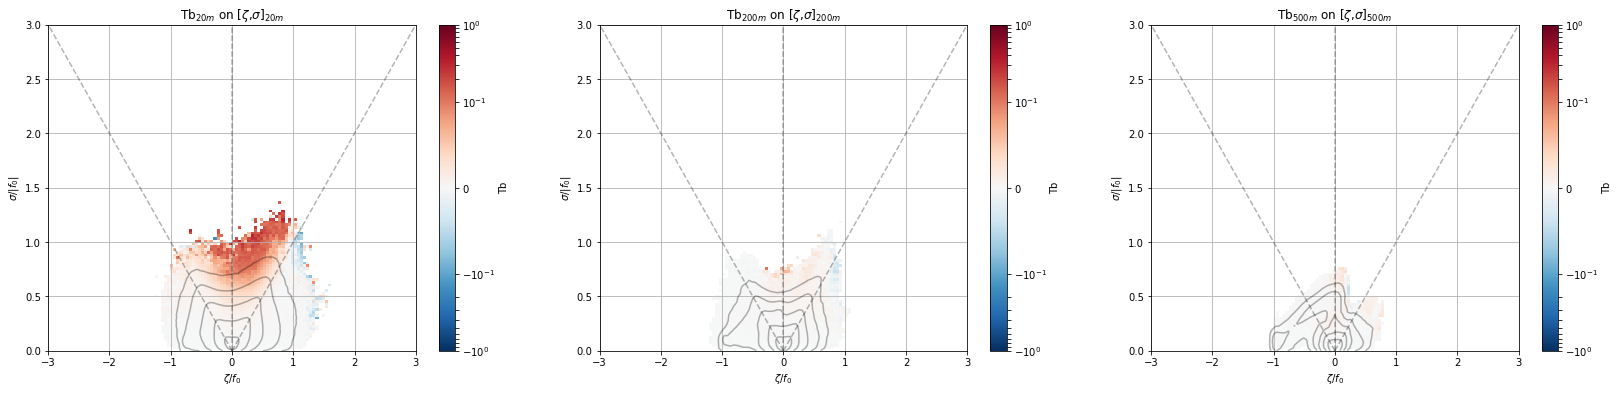

In [41]:
# w
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
W = ((E/N).mean(dim='time').T)*filter01

fig, ax = plt.subplots(figsize=(28,6))

ax = plt.subplot(131)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(1e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('Tb')
ax.set_title('Tb$_{20m}$ on [$\zeta$,$\sigma$]$_{20m}$')


ax = plt.subplot(132)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=1), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(1e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('Tb')
ax.set_title('Tb$_{200m}$ on [$\zeta$,$\sigma$]$_{200m}$')


ax = plt.subplot(133)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=2), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(1e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('Tb')
ax.set_title('Tb$_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')


# DIV

In [35]:
ndepth = [1, 10, 20]
vor_bin = np.linspace(-3, 3, 120)
sr_bin = np.linspace(0, 3, 120)

N = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              bins=[vor_bin, sr_bin], 
              dim=['lat', 'lon'], 
              block_size=None
             )

E = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              bins=[vor_bin, sr_bin], 
              weights= ds_vs.div_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(),
              dim=['lat', 'lon'], 
              block_size=None
             )

binbox01 =  (vor_bin[1]-vor_bin[0])*(sr_bin[1]-sr_bin[0])
girbNums01 = (len(ds_vs.zeta_single.lat)-2)*(len(ds_vs.zeta_single.lon)-2)

/dev/shm/pbs.484282.datarmor0/ipykernel_43045/3960508211.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.484282.datarmor0/ipykernel_43045/3960508211.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.484282.datarmor0/ipykernel_43045/3960508211.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eith

Text(0.5, 1.0, 'DIV$_{500m}$ on [$\\zeta$,$\\sigma$]$_{500m}$')

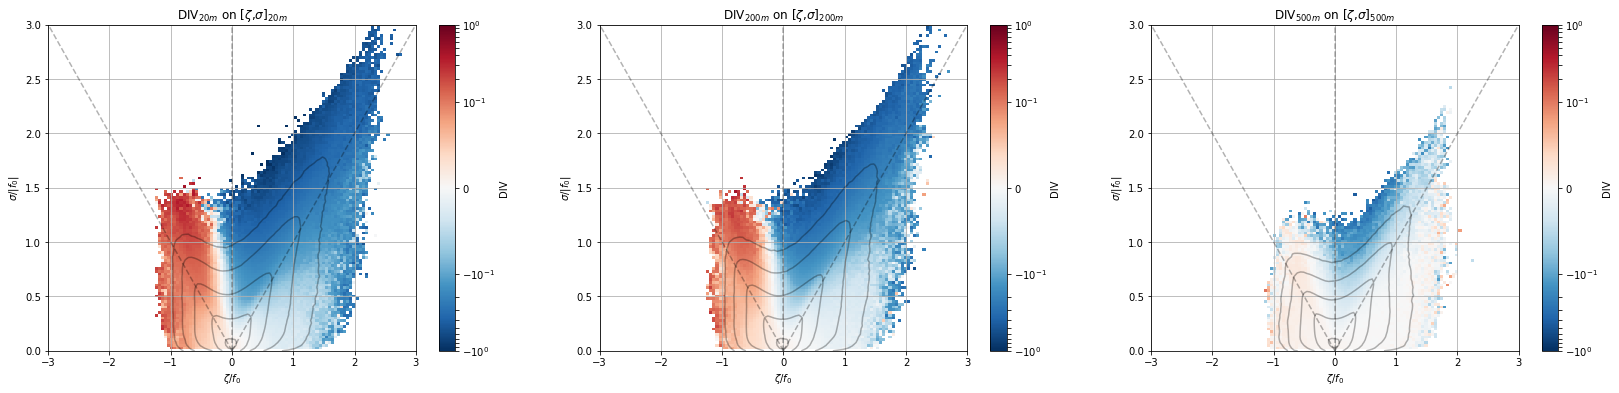

In [37]:
# w
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
W = ((E/N).mean(dim='time').T)*filter01

fig, ax = plt.subplots(figsize=(28,6))

ax = plt.subplot(131)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(1e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('DIV')
ax.set_title('DIV$_{20m}$ on [$\zeta$,$\sigma$]$_{20m}$')


ax = plt.subplot(132)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=1), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(1e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('DIV')
ax.set_title('DIV$_{200m}$ on [$\zeta$,$\sigma$]$_{200m}$')


ax = plt.subplot(133)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=2), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(1e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('DIV')
ax.set_title('DIV$_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')


In [38]:
ndepth = [30, 40, 50]
vor_bin = np.linspace(-3, 3, 120)
sr_bin = np.linspace(0, 3, 120)

N = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              bins=[vor_bin, sr_bin], 
              dim=['lat', 'lon'], 
              block_size=None
             )

E = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              bins=[vor_bin, sr_bin], 
              weights= ds_vs.div_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(),
              dim=['lat', 'lon'], 
              block_size=None
             )

binbox01 =  (vor_bin[1]-vor_bin[0])*(sr_bin[1]-sr_bin[0])
girbNums01 = (len(ds_vs.zeta_single.lat)-2)*(len(ds_vs.zeta_single.lon)-2)

/dev/shm/pbs.484282.datarmor0/ipykernel_43045/3960508211.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.484282.datarmor0/ipykernel_43045/3960508211.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.484282.datarmor0/ipykernel_43045/3960508211.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eith

Text(0.5, 1.0, 'DIV$_{500m}$ on [$\\zeta$,$\\sigma$]$_{500m}$')

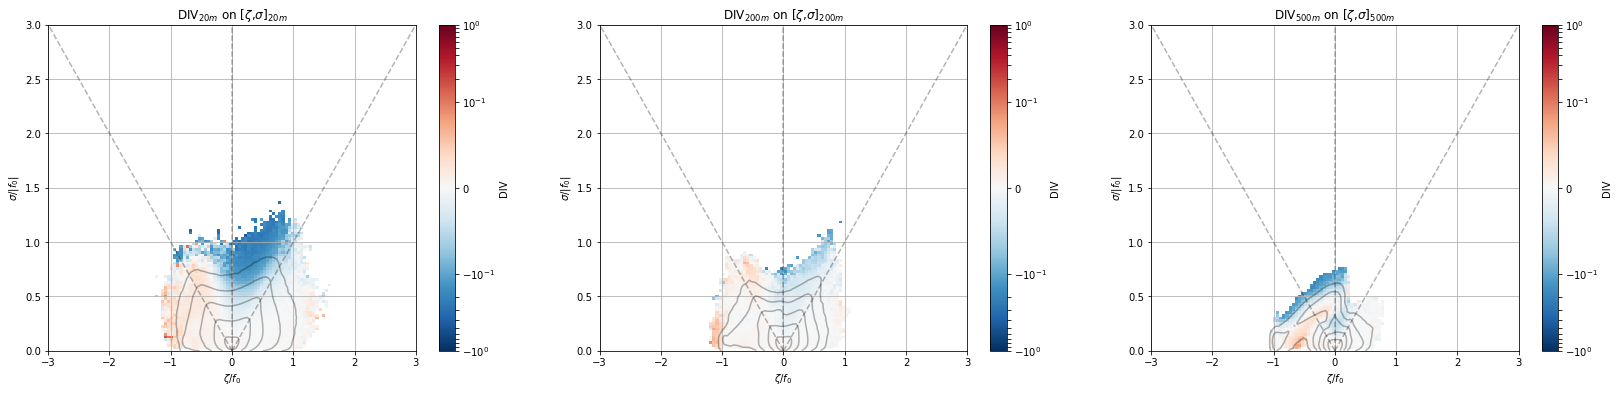

In [39]:
# w
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
W = ((E/N).mean(dim='time').T)*filter01

fig, ax = plt.subplots(figsize=(28,6))

ax = plt.subplot(131)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(1e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('DIV')
ax.set_title('DIV$_{20m}$ on [$\zeta$,$\sigma$]$_{20m}$')


ax = plt.subplot(132)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=1), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(1e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('DIV')
ax.set_title('DIV$_{200m}$ on [$\zeta$,$\sigma$]$_{200m}$')


ax = plt.subplot(133)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=2), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(1e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('DIV')
ax.set_title('DIV$_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')


In [43]:
cluster.close()